### Amorphous classification

in the presence of crystalline scattering

In [170]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.patches import Circle
from time import time
from scipy.ndimage.filters import gaussian_filter
from numpy.linalg import lstsq
from sklearn.decomposition import NMF
from scipy.ndimage.morphology import binary_closing, binary_opening, binary_dilation, binary_erosion
from skimage.measure import label

from py4DSTEM.process.calibration import get_probe_size
from py4DSTEM.process.classification import get_class_DP

In [171]:
# Examine file contents

fp_dc = "/home/ben/Data/20190312_irradiatedPyrochlore_Janish/FZ-GTO-110-MO05-38_bin2.h5"
fp_pr = "/home/ben/Data/20190312_irradiatedPyrochlore_Janish/38_processing_bin2_v2.h5"
browser_dc = py4DSTEM.file.io.FileBrowser(fp_dc)
browser_pr = py4DSTEM.file.io.FileBrowser(fp_pr)
browser_dc.show_dataobjects()
print('')
browser_pr.show_dataobjects()

 Index                  Name                        Type        
   0    datacube                            DataCube            

 Index                  Name                        Type        
   0    braggvectormap                      DiffractionSlice    
   1    probe                               DiffractionSlice    
   2    diffraction_shifts                  RealSlice           
   3    Braggpeaks_v2                       PointListArray      
   4    shifted_Braggpeaks                  PointListArray      


In [172]:
# Load data

dc = browser_dc.get_dataobject('datacube')
braggpeaks = browser_pr.get_dataobject('Braggpeaks_v2')
probe = browser_pr.get_dataobject('probe').data2D['probe']
braggvectormap = browser_pr.get_dataobject('braggvectormap').data2D
diffraction_shifts = browser_pr.get_dataobject('diffraction_shifts')

browser_dc.close()
browser_pr.close()

In [173]:
ave_im = np.average(dc.data4D,axis=(2,3))

### Mask Bragg scattering

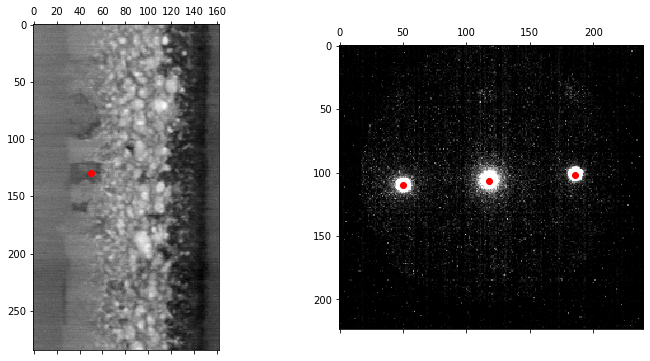

In [375]:
rx,ry = 130,50
power = 0.05

peaks = braggpeaks.get_pointlist(rx,ry)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(ave_im)
ax1.scatter(ry,rx,color='r')
ax2.matshow(dc.data4D[rx,ry,:,:]**power, vmin=np.median(dc.data4D[rx,ry,:,:]**power),vmax=np.median(dc.data4D[rx,ry,:,:]**power+4*np.std(dc.data4D[rx,ry,:,:]**power)))
ax2.scatter(peaks.data['qy'],peaks.data['qx'],color='r')
plt.show()

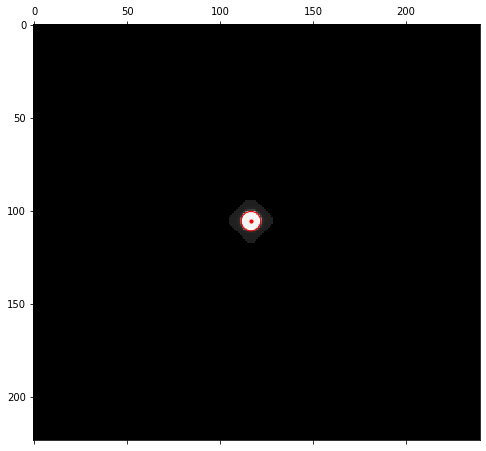

In [175]:
# Get disk radius

thresh_lower = 0.001
thresh_upper = 0.999
N = 100

power = 0.5

probe_radius,x0,y0 = get_probe_size(probe, thresh_lower=thresh_lower, thresh_upper=thresh_upper, N=N)

# Show
fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(probe**power)
ax.scatter(y0,x0,color='r',s=10)
circle = Circle((y0,x0),r,fill=False,edgecolor='r',linewidth=1)
ax.add_patch(circle)
plt.show()

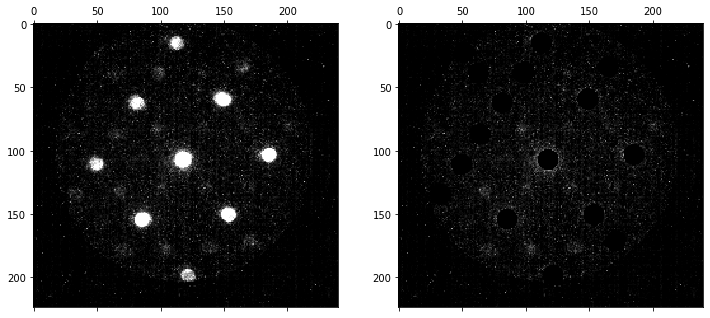

In [176]:
# Get mask

expand_rad = 3
power = 0.3
Rx,Ry = 100,120

r2 = (probe_radius + expand_rad)**2
mask = np.ones((dc.Q_Nx,dc.Q_Ny))
qy,qx = np.meshgrid(np.arange(dc.Q_Ny),np.arange(dc.Q_Nx))
peaks = braggpeaks.get_pointlist(Rx,Ry)
for i in range(peaks.length):
    mask_currpeak = (qx-peaks.data['qx'][i])**2 + (qy-peaks.data['qy'][i])**2 > r2
    mask = np.logical_and(mask,mask_currpeak)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(dc.data4D[Rx,Ry,:,:]**power, vmin=np.median(dc.data4D[Rx,Ry,:,:]**power),vmax=np.median(dc.data4D[Rx,Ry,:,:]**power+4*np.std(dc.data4D[Rx,Ry,:,:]**power)))
ax2.matshow(mask*dc.data4D[Rx,Ry,:,:]**power, vmin=np.median(dc.data4D[Rx,Ry,:,:]**power),vmax=np.median(dc.data4D[Rx,Ry,:,:]**power+4*np.std(dc.data4D[Rx,Ry,:,:]**power)))
plt.show()

### Calculate radial integrals

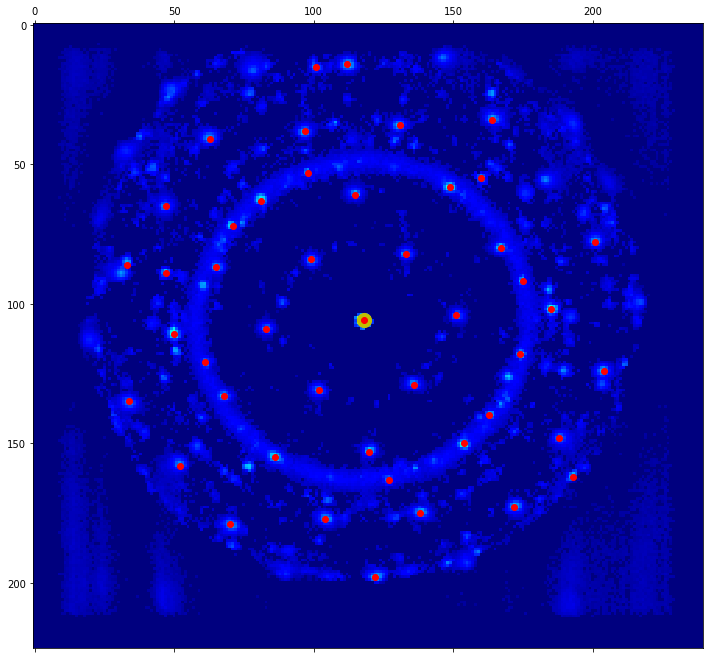

In [177]:
# Find unscattered beam

sigma=2
edgeBoundary=10
minSpacing=10
minRelativeIntensity=0.001
relativeToPeak=0
maxNumPeaks=50
subpixel='multicorr'

x,y,intensity = py4DSTEM.process.utils.get_maxima_2D(braggvectormap,
                                           sigma=sigma,
                                           edgeBoundary=edgeBoundary,
                                           minSpacing=minSpacing,
                                           minRelativeIntensity=minRelativeIntensity,
                                           maxNumPeaks=maxNumPeaks,
                                           subpixel=subpixel)
x0,y0 = x[0],y[0]

fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(braggvectormap**0.2,cmap='jet')
ax.scatter(y0,x0,color='y',s=200)
ax.scatter(y,x,color='r')
plt.show()

In [178]:
# Get center spot positions

max_dist = 10

x0_ar = np.zeros((dc.R_Nx,dc.R_Ny))
y0_ar = np.zeros((dc.R_Nx,dc.R_Ny))
mask = np.zeros((dc.R_Nx,dc.R_Ny),dtype=bool)
for Rx in range(dc.R_Nx):
    for Ry in range(dc.R_Ny):
        peaks = braggpeaks.get_pointlist(Rx,Ry)
        center_ind = np.argmin(np.hypot(peaks.data['qx']-x0,peaks.data['qy']-y0))
        if np.hypot(peaks.data['qx'][center_ind]-x0,peaks.data['qy'][center_ind]-y0) < max_dist:
            x0_ar[Rx,Ry] = peaks.data['qx'][center_ind]
            y0_ar[Rx,Ry] = peaks.data['qy'][center_ind]
            mask[Rx,Ry] = True

assert(np.sum(mask==False)==0)

/home/ben/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


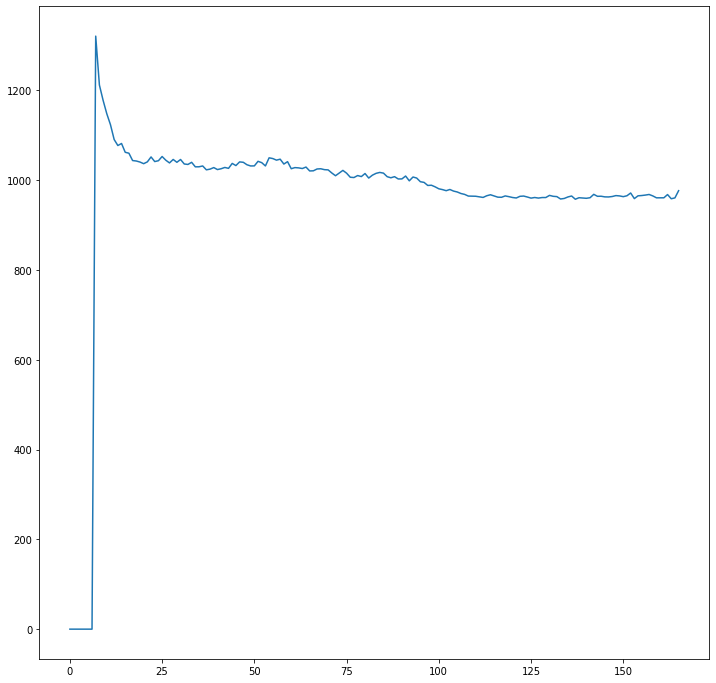

In [179]:
# Get radial integral for one DP

expand_rad = 3   # Mask expansion
Rx,Ry = 100,120

# Get mask
r2 = (probe_radius + expand_rad)**2
mask = np.ones((dc.Q_Nx,dc.Q_Ny))
qy,qx = np.meshgrid(np.arange(dc.Q_Ny),np.arange(dc.Q_Nx))
peaks = braggpeaks.get_pointlist(Rx,Ry)
for i in range(peaks.length):
    mask_currpeak = (qx-peaks.data['qx'][i])**2 + (qy-peaks.data['qy'][i])**2 > r2
    mask = np.logical_and(mask,mask_currpeak)

# Get radial integrals
profile_unnormed = py4DSTEM.process.utils.radial_integral(mask*dc.data4D[Rx,Ry,:,:],x0_ar[Rx,Ry],y0_ar[Rx,Ry])[1]
normalization = py4DSTEM.process.utils.radial_integral(mask,x0_ar[Rx,Ry],y0_ar[Rx,Ry])[1]
radial_profile = np.where(normalization!=0,profile_unnormed/normalization.astype(float),0)

fig,ax = plt.subplots(figsize=(12,12))
ax.plot(np.arange(len(radial_profile)),radial_profile)
plt.show()

In [180]:
# Get number of bins for smallest profile

prof_length_ar = np.zeros((dc.R_Nx,dc.R_Ny,4))
prof_length_ar[:,:,0] = x0_ar
prof_length_ar[:,:,1] = dc.Q_Nx - x0_ar
prof_length_ar[:,:,2] = y0_ar
prof_length_ar[:,:,3] = dc.Q_Ny - y0_ar

prof_length = int(np.min(prof_length_ar))

In [181]:
# Get radial all integrals

expand_rad = 3   # Mask expansion

t0 = time()
radial_profiles = np.zeros((dc.R_Nx,dc.R_Ny,prof_length))
qy,qx = np.meshgrid(np.arange(dc.Q_Ny),np.arange(dc.Q_Nx))
for Rx in range(dc.R_Nx):
    for Ry in range(dc.R_Ny):        
        # Get mask
        r2 = (probe_radius + expand_rad)**2
        mask = np.ones((dc.Q_Nx,dc.Q_Ny))
        peaks = braggpeaks.get_pointlist(Rx,Ry)
        for i in range(peaks.length):
            mask_currpeak = (qx-peaks.data['qx'][i])**2 + (qy-peaks.data['qy'][i])**2 > r2
            mask = np.logical_and(mask,mask_currpeak)

        # Get radial integrals
        profile_unnormed = py4DSTEM.process.utils.radial_integral(mask*dc.data4D[Rx,Ry,:,:],x0_ar[Rx,Ry],y0_ar[Rx,Ry])[1]
        normalization = py4DSTEM.process.utils.radial_integral(mask,x0_ar[Rx,Ry],y0_ar[Rx,Ry])[1]
        radial_profile = np.where(normalization!=0,profile_unnormed/normalization.astype(float),0)
        radial_profiles[Rx,Ry,:] = radial_profile[:prof_length]
        
        # Progress bar
        py4DSTEM.process.utils.print_progress_bar(Rx*dc.R_Ny+Ry+1, dc.R_Nx*dc.R_Ny,
                                                  prefix="Analyzing:",
                                                  suffix="Complete",
                                                  length=50)
t = time() - t0
print("Analyzed {} diffraction patterns in {}h {}m {}s".format(dc.R_N, t//3600, t//60, int(t%60)))

/home/ben/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


Analyzing: |**************************************************| 100.0% Complete
Analyzed 46170 diffraction patterns in 0.0h 7.0m 39s


### Preprocess for NMF

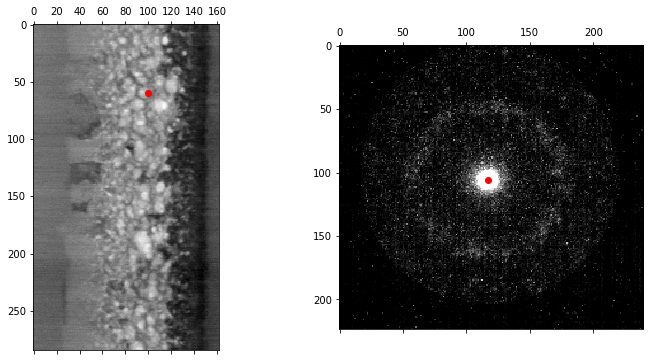

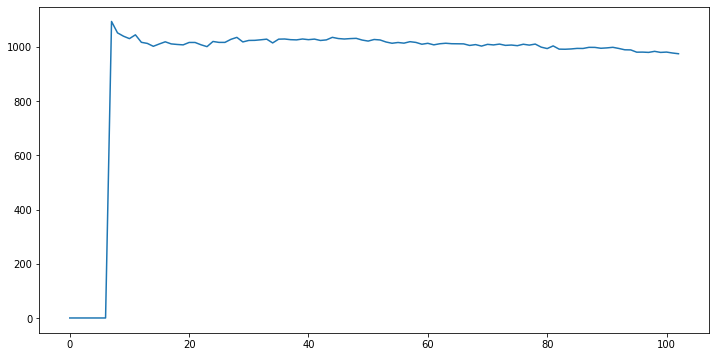

In [322]:
# Show

rx,ry = 60,100
power = 0.05

peaks = braggpeaks.get_pointlist(rx,ry)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(ave_im)
ax1.scatter(ry,rx,color='r')
ax2.matshow(dc.data4D[rx,ry,:,:]**power, vmin=np.median(dc.data4D[rx,ry,:,:]**power),vmax=np.median(dc.data4D[rx,ry,:,:]**power+4*np.std(dc.data4D[rx,ry,:,:]**power)))
ax2.scatter(peaks.data['qy'],peaks.data['qx'],color='r')
plt.show()

fig,ax = plt.subplots(figsize=(12,6))
ax.plot(np.arange(len(radial_profiles[Rx,Ry,:])),radial_profiles[Rx,Ry,:])
plt.show()

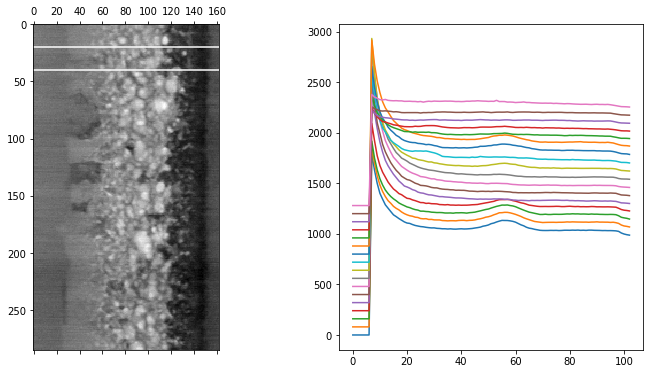

In [366]:
# Show line profile

xmin,xmax = 20,40
offset = 8

averaged_profiles = np.average(radial_profiles[xmin:xmax,:,:],axis=0)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(ave_im)
ax1.hlines((xmin,xmax),ax1.get_xlim()[0],ax1.get_xlim()[1],color='w')
for Ry in range(dc.R_Ny):
    if Ry%10==0:
        ax2.plot(np.arange(radial_profiles.shape[2]),averaged_profiles[Ry,:]+Ry*offset)
plt.show()

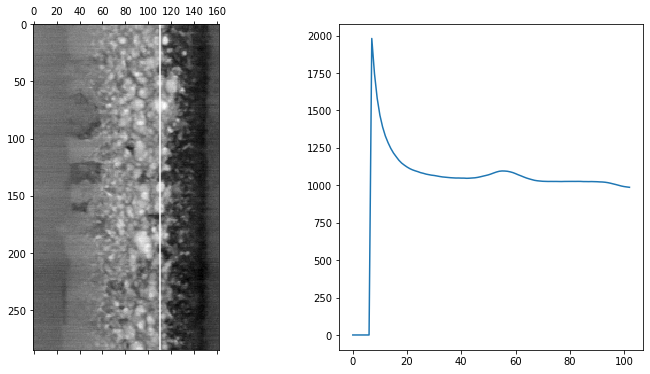

In [324]:
Ry = 110

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(ave_im)
ax1.vlines(Ry,ax1.get_ylim()[0],ax1.get_ylim()[1],color='w')
ax2.plot(np.arange(radial_profiles.shape[2]),averaged_profiles[Ry,:])
plt.show()

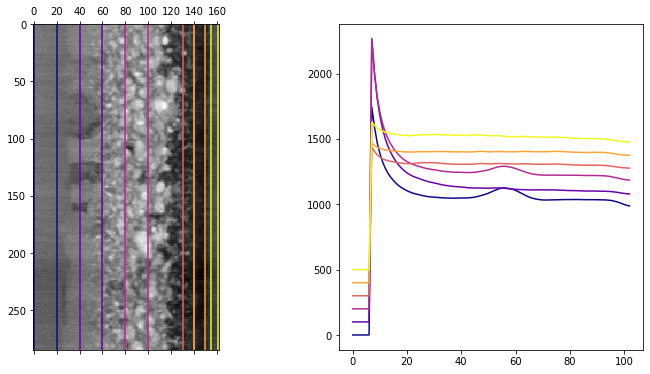

In [325]:
# Select some initial classes by Ry ranges

Nc0 = 6
class1_Ryrange = [0,20]
class2_Ryrange = [40,60]
class3_Ryrange = [80,100]
class4_Ryrange = [130,140]
class5_Ryrange = [140,150]
class6_Ryrange = [155,161]

offset = 100

class_ranges = np.vstack((class1_Ryrange,class2_Ryrange,class3_Ryrange,
                          class4_Ryrange,class5_Ryrange,class6_Ryrange))

# Get colors
cmap = get_cmap('plasma')
colors = [cmap(i) for i in np.linspace(0,1,Nc0)]

# Get average profiles
class_profiles = np.zeros((Nc0,averaged_profiles.shape[1]))
for i in range(Nc0):
    class_profiles[i,:] = np.average(averaged_profiles[class_ranges[i,0]:class_ranges[i,1],:],axis=0)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(ave_im)
for i in range(Nc0):
    ax1.vlines(class_ranges[i,:],ax1.get_ylim()[0],ax1.get_ylim()[1],color=colors[i])
    ax2.plot(np.arange(class_profiles.shape[1]),class_profiles[i,:]+i*offset,color=colors[i])
plt.show()

In [435]:
# Set bin range and rebin size, if any

bin_min,bin_max = 30,90
rebin_factor = 2
Nbins = (bin_max-bin_min)//rebin_factor

profiles_rebinned = np.zeros((dc.R_Nx,dc.R_Ny,Nbins))
for Rx in range(dc.R_Nx):
    for Ry in range(dc.R_Ny):
        for i in range(rebin_factor):
            profiles_rebinned[Rx,Ry,:] += radial_profiles[Rx,Ry,bin_min+i:bin_max+i:rebin_factor]
profiles_rebinned = profiles_rebinned/float(rebin_factor)

#profiles_rebinned -= np.min(profiles_rebinned,axis=2)
#stds = np.std(profiles_rebinned,axis=(0,1))
#profiles_rebinned = profiles_rebinned/stds #[:,:,np.newaxis]

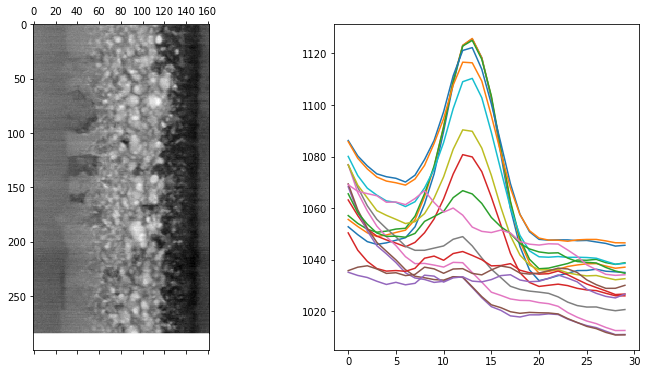

In [436]:
# Show line profile

xmin,xmax = 0,285
offset = .2

averaged_profiles = np.average(profiles_rebinned[xmin:xmax,:,:],axis=0)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(ave_im)
ax1.hlines((xmin,xmax),ax1.get_xlim()[0],ax1.get_xlim()[1],color='w')
for Ry in range(dc.R_Ny):
    if Ry%10==0:
        ax2.plot(np.arange(averaged_profiles.shape[1]),averaged_profiles[Ry,:]+Ry*offset)
plt.show()

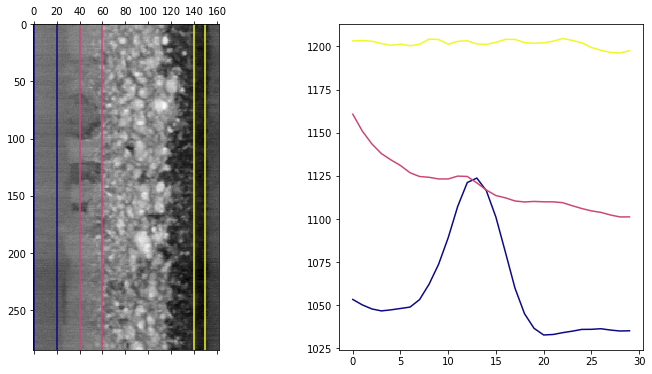

In [564]:
# Select some initial classes by Ry ranges

Nc0 = 3
class1_Ryrange = [0,20]
class2_Ryrange = [40,60]
#class3_Ryrange = [80,100]
#class4_Ryrange = [130,140]
class5_Ryrange = [140,150]
#class6_Ryrange = [155,161]

offset = 100

# class_ranges = np.vstack((class1_Ryrange,class2_Ryrange,class3_Ryrange,
#                           class4_Ryrange,class5_Ryrange,class6_Ryrange))
class_ranges = np.vstack((class1_Ryrange,class2_Ryrange,class5_Ryrange))

# Get colors
cmap = get_cmap('plasma')
colors = [cmap(i) for i in np.linspace(0,1,Nc0)]

# Get average profiles
class_profiles = np.zeros((Nc0,averaged_profiles.shape[1]))
for i in range(Nc0):
    class_profiles[i,:] = np.average(averaged_profiles[class_ranges[i,0]:class_ranges[i,1],:],axis=0)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(ave_im)
for i in range(Nc0):
    ax1.vlines(class_ranges[i,:],ax1.get_ylim()[0],ax1.get_ylim()[1],color=colors[i])
    ax2.plot(np.arange(class_profiles.shape[1]),class_profiles[i,:]+i*offset,color=colors[i])
plt.show()

### NMF

In [565]:
# Construct matrices

N_c = Nc0
N_feat = class_profiles.shape[1]
N_meas = dc.R_Nx*dc.R_Ny

# X
X = np.zeros((N_feat,N_meas))
for Rx in range(dc.R_Nx):
    for Ry in range(dc.R_Ny):
        R = Rx*dc.R_Ny + Ry
        X[:,R] = profiles_rebinned[Rx,Ry,:]

# W
W = np.zeros((N_feat,N_c))
for i in range(N_c):
    W[:,i] = class_profiles[i,:]

# H
H = lstsq(W,X,rcond=None)[0]
H = np.where(H<0,0,H)

In [566]:
# Run nmf

max_iterations = 500

nmf = NMF(n_components=N_c, init='custom', max_iter=max_iterations)
W_next = nmf.fit_transform(X,W=W,H=H)
H_next = nmf.components_

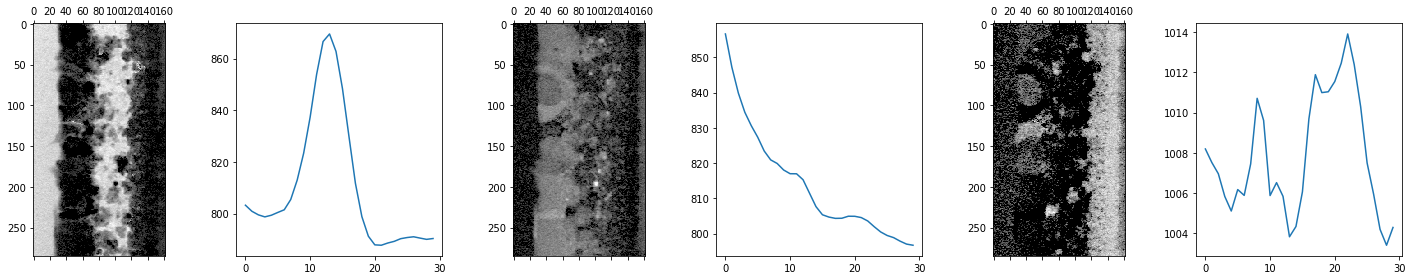

In [567]:
# Get / show classes

class_images = H.reshape((N_c,dc.R_Nx,dc.R_Ny))
class_profiles = np.swapaxes(W_next,0,1)

fig,axs = plt.subplots(1,2*N_c,figsize=(20,4))
for i in range(N_c):
    ax1,ax2 = axs[2*i],axs[2*i+1]
    ax1.matshow(class_images[i,:,:]**0.5)
    ax2.plot(np.arange(len(class_profiles[i,:])),class_profiles[i,:])
plt.tight_layout()
plt.show()

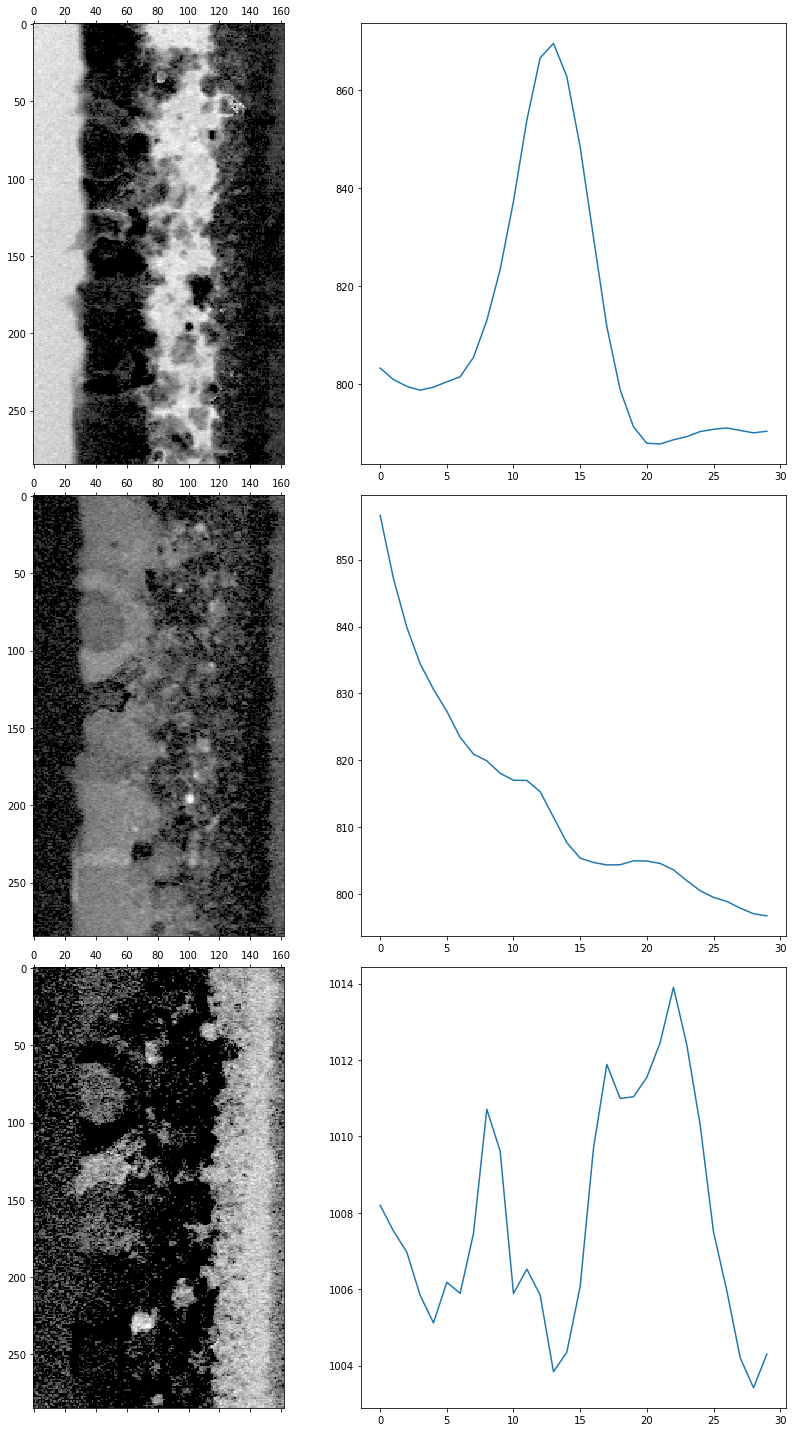

In [568]:
fig,axs = plt.subplots(N_c,2,figsize=(12,20))
for i in range(N_c):
    ax1,ax2 = axs[i,:]
    ax1.matshow(class_images[i,:]**0.5)
    ax2.plot(np.arange(len(class_profiles[i,:])),class_profiles[i,:])
plt.tight_layout()
plt.show()

### Split first class

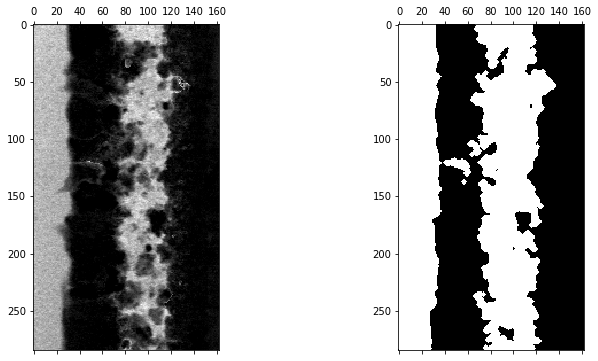

In [569]:
split_class_index = 0
thresh = 0.2
sigma = 1
expand_mask = 1

old_class_image = class_images[split_class_index,:] 

# Get mask
mask = gaussian_filter(old_class_image,sigma) > thresh
mask = binary_opening(mask,iterations=1)
mask = binary_closing(mask,iterations=1)
mask = binary_dilation(mask,iterations=expand_mask)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(old_class_image)
ax2.matshow(mask)
plt.show()

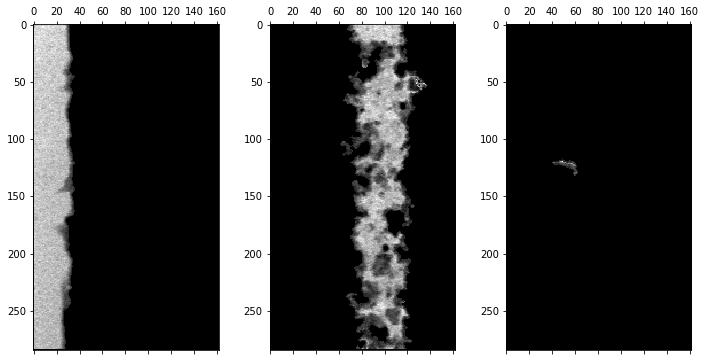

In [570]:
# Get connected regions
labels,nlabels = label(mask, background=0, return_num=True, connectivity=2)
new_class_images = np.zeros((nlabels,dc.R_Nx,dc.R_Ny))
for i in range(nlabels):
    classmask = labels==i+1
    classmask = binary_erosion(classmask,iterations=expand_mask)
    new_class_images[i,:,:] = old_class_image*classmask

# Show
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,6))
ax1.matshow(new_class_images[0,:,:])
ax2.matshow(new_class_images[1,:,:])
ax3.matshow(new_class_images[2,:,:])
plt.show()

In [571]:
# Edit class image matrix
new_class_images = np.concatenate((new_class_images[0,:,:][np.newaxis,:,:],new_class_images[1,:,:][np.newaxis,:,:]))
class_images = np.concatenate((new_class_images,class_images[1:,:,:]))
N_c = class_images.shape[0]

# Edit class profiles
class_profiles = np.concatenate((class_profiles[0,:][np.newaxis,:],class_profiles))

In [572]:
# Get average diffraction patterns and average radial profiles

shift_DPs = True    # NOTE: if True, this cell is *slow*

# Radial profiles
class_radial_profiles = np.zeros((N_c,bin_max-bin_min))
for Rx in range(dc.R_Nx):
    for Ry in range(dc.R_Ny):
        for i in range(N_c):
            class_radial_profiles[i,:] += class_images[i,Rx,Ry]*radial_profiles[Rx,Ry,bin_min:bin_max]
for i in range(N_c):
    class_radial_profiles[i,:] /= np.sum(class_images[i,:,:])
            
# Average diffraction patterns
class_DPs = np.zeros((N_c,dc.Q_Nx,dc.Q_Ny))
for i in range(N_c):
    if shift_DPs:
        class_DPs[i,:,:] = get_class_DP(dc, class_images[i,:,:],
                                        xshifts=diffraction_shifts.data2D['x'],
                                        yshifts=diffraction_shifts.data2D['y'])
    else:
        class_DPs[i,:,:] = get_class_DP(dc, class_images[i,:,:])

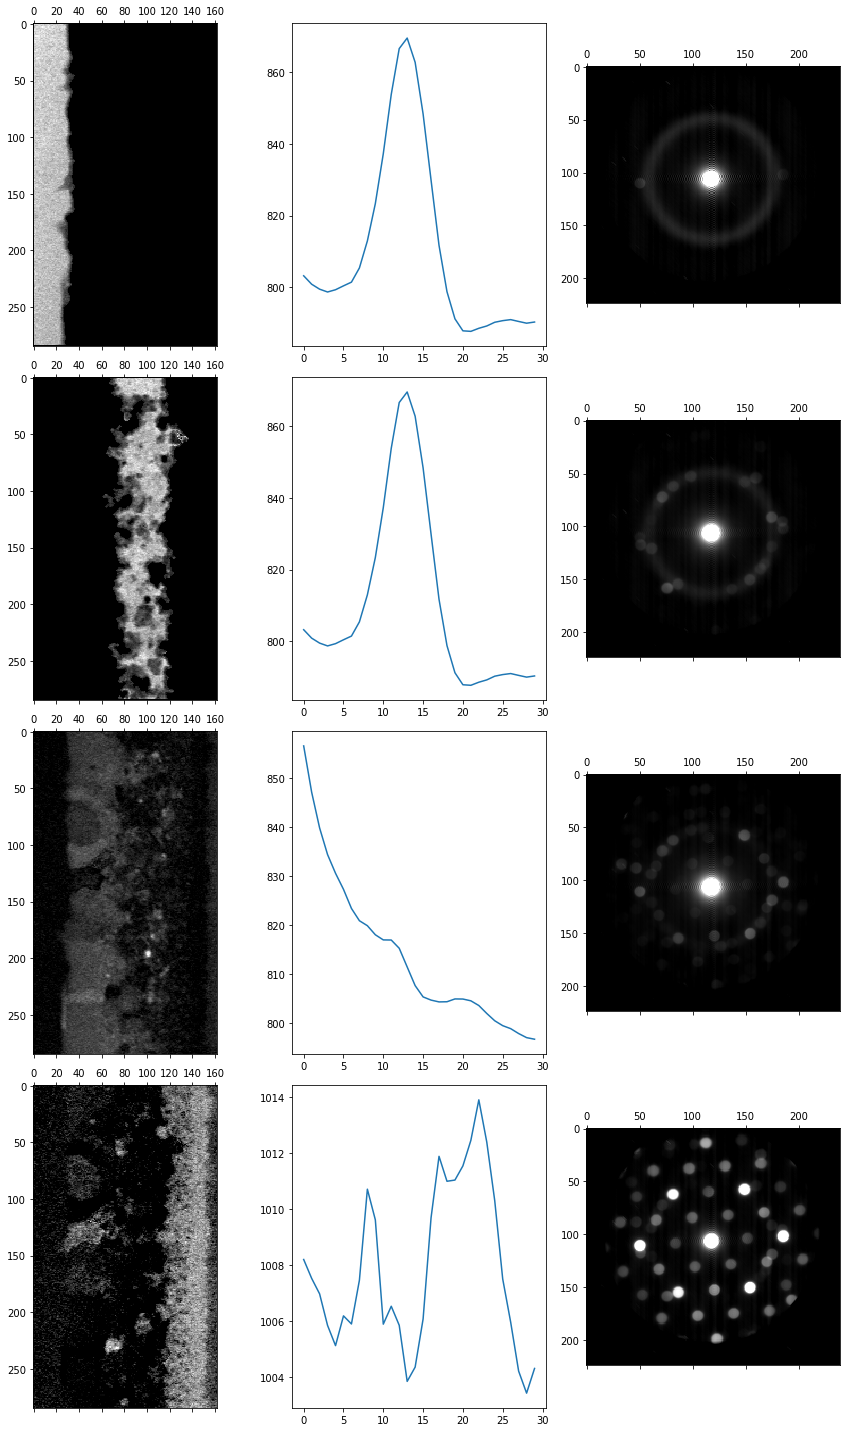

In [576]:
# Show

im_power=1
dp_power=0.1
show_nmf_profiles = True    # If False, show average radial profiles. If True, show nmf profiles

fig,axs = plt.subplots(N_c,3,figsize=(12,20))
for i in range(N_c):
    ax1,ax2,ax3 = axs[i,:]
    ax1.matshow(class_images[i,:]**im_power)
    if show_nmf_profiles:    
        ax2.plot(np.arange(len(class_profiles[i,:])),class_profiles[i,:])
    else:
        ax2.plot(np.arange(len(class_radial_profiles[i,:])),class_radial_profiles[i,:])
    ax3.matshow(class_DPs[i,:,:]**dp_power, vmin=np.median(class_DPs[i,:,:]**dp_power),vmax=np.median(class_DPs[i,:,:]**dp_power+4*np.std(class_DPs[i,:,:]**dp_power)))
plt.tight_layout()
plt.show()